<div align="center">
  <h1>Лабораторная работа №4</h1>
</div>

<div align="center">
  <h2>Отчет о выполнении</h2>
</div>

<div align="right">
  <h3>Студента 3 курса 8 группы</h3>
  <h3>Добрицкого Артема</h3>
</div>

# 1. Загрузка данных

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

file = pd.read_csv("../data/Annual 2005-2011.csv")

# Дискриминатный анализ даных

## 2. Кластерный анализ

Выбираем финансовые колонки для анализа

In [71]:
financial_columns = [col for col in file.columns if any(x in col.lower() for x in ['ratio', 'coef', 'k', 'financial'])]
if len(financial_columns) == 0:
    financial_columns = file.select_dtypes(include=[np.number]).columns.tolist()
    financial_columns = financial_columns[:15]
print(f"Используемые финансовые показатели: {financial_columns}")
X_cluster = file[financial_columns].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

Используемые финансовые показатели: ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k12', 'k13', 'k14', 'k15', 'k16', 'k17', 'k18', 'k19', 'k20']



 определяем оптимальное число кластеров


Распределение по кластерам:
cluster
1.0     779
2.0     225
3.0     670
4.0    1021
Name: count, dtype: int64


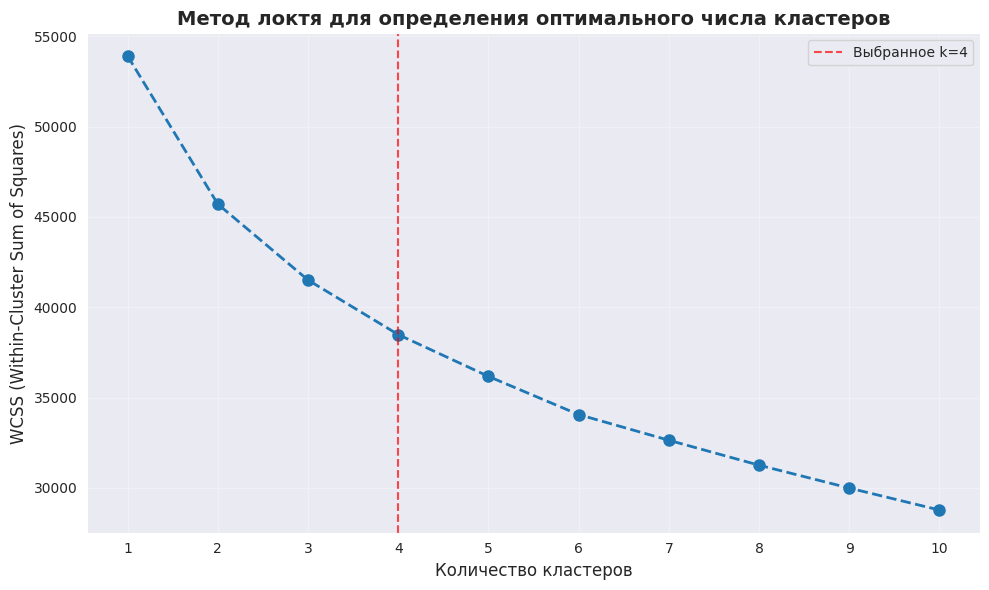

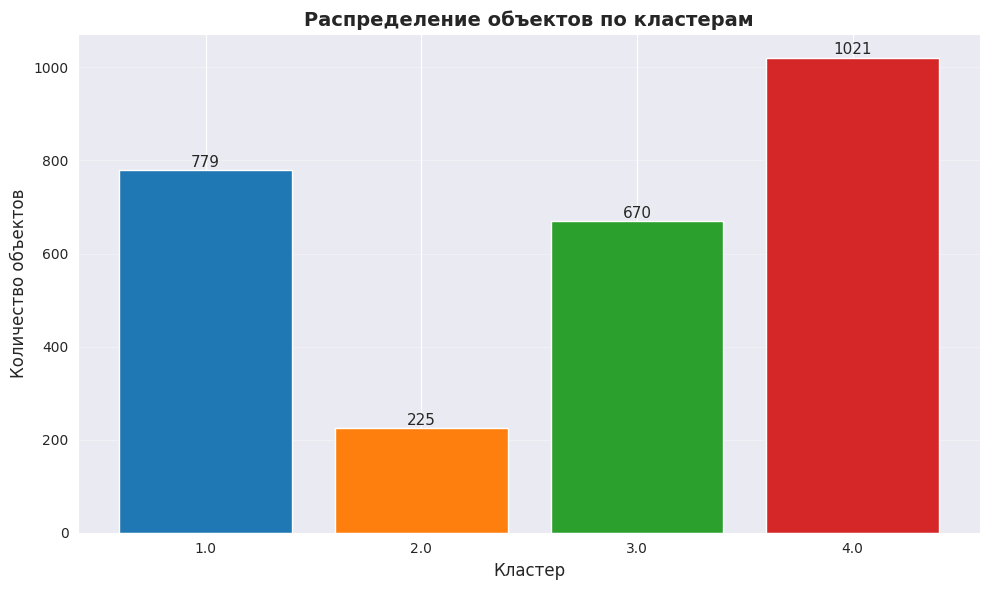

In [72]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
file_clustered = file.copy()
file_clustered.loc[X_cluster.index, 'cluster'] = cluster_labels + 1  # Классы 1-4

print("\nРаспределение по кластерам:")
print(file_clustered['cluster'].value_counts().sort_index())

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', linewidth=2, markersize=8)
plt.title('Метод локтя для определения оптимального числа кластеров', fontsize=14, fontweight='bold')
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.xticks(range(1, 11))
plt.grid(True, alpha=0.3)
plt.axvline(x=4, color='red', linestyle='--', alpha=0.7, label='Выбранное k=4')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
cluster_counts = file_clustered['cluster'].value_counts().sort_index()
bars = plt.bar(cluster_counts.index.astype(str), cluster_counts.values,
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

plt.title('Распределение объектов по кластерам', fontsize=14, fontweight='bold')
plt.xlabel('Кластер', fontsize=12)
plt.ylabel('Количество объектов', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Добавление значений над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

#### 3. Основная часть Дискриминантного анализа

In [73]:
if 'rating' not in file.columns:
    file_clustered['rating'] = file_clustered['cluster']
X = file_clustered[financial_columns].dropna()
y = file_clustered.loc[X.index, 'rating']
print(f"Размерность данных: {X.shape}")
print(f"Распределение классов:")
print(y.value_counts().sort_index())

Размерность данных: (2695, 20)
Распределение классов:
rating
1.0     779
2.0     225
3.0     670
4.0    1021
Name: count, dtype: int64


Разделяем на обучающую и тестовую выборки (80%/20%) и классифицируем исходную выборку

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nОбучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
scaler_lda = StandardScaler()
X_train_scaled = scaler_lda.fit_transform(X_train)
X_test_scaled = scaler_lda.transform(X_test)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
y_train_pred = lda.predict(X_train_scaled)


Обучающая выборка: (2156, 20)
Тестовая выборка: (539, 20)



а) РЕЗУЛЬТАТЫ ПЕРЕКЛАССИФИКАЦИИ ОБУЧАЮЩЕЙ ВЫБОРКИ


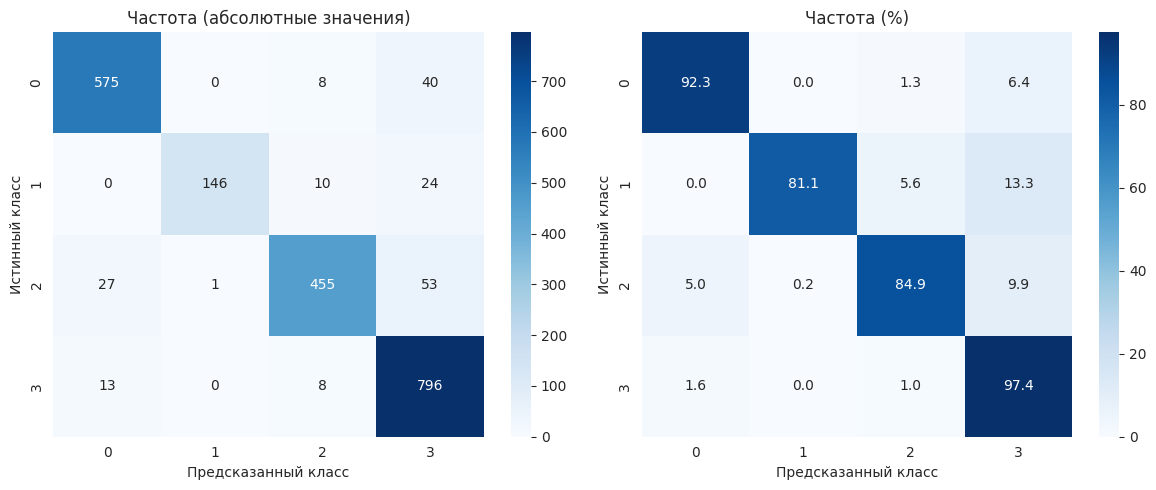

Процент верно классифицированных наблюдений: 91.5%


In [75]:
print("\nа) РЕЗУЛЬТАТЫ ПЕРЕКЛАССИФИКАЦИИ ОБУЧАЮЩЕЙ ВЫБОРКИ")
cm_train = confusion_matrix(y_train, y_train_pred)
cm_train_percent = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Частота (абсолютные значения)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

plt.subplot(1, 2, 2)
sns.heatmap(cm_train_percent, annot=True, fmt='.1f', cmap='Blues')
plt.title('Частота (%)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

plt.tight_layout()
plt.show()
train_accuracy = np.mean(y_train == y_train_pred) * 100
print(f"Процент верно классифицированных наблюдений: {train_accuracy:.1f}%")


б) РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ ТЕСТОВОЙ ВЫБОРКИ


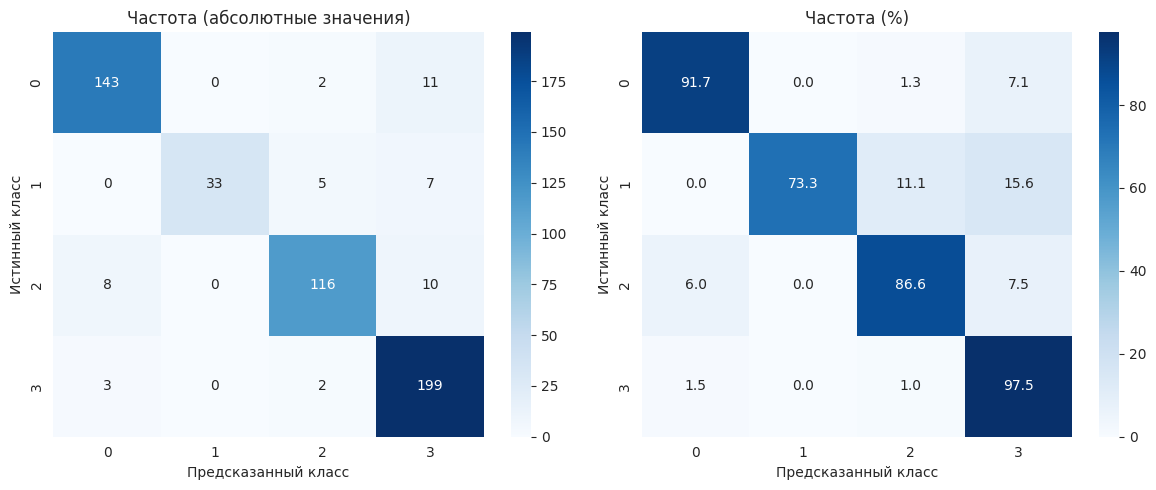

Процент верно классифицированных наблюдений в тестовой выборке: 91.1%


In [76]:
y_test_pred = lda.predict(X_test_scaled)
print("\nб) РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ ТЕСТОВОЙ ВЫБОРКИ")
cm_test = confusion_matrix(y_test, y_test_pred)
cm_test_percent = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Частота (абсолютные значения)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test_percent, annot=True, fmt='.1f', cmap='Blues')
plt.title('Частота (%)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')

plt.tight_layout()
plt.show()

test_accuracy = np.mean(y_test == y_test_pred) * 100
print(f"Процент верно классифицированных наблюдений в тестовой выборке: {test_accuracy:.1f}%")

Объясненная дисперсия дискриминантами:
Дискриминант 1: 0.541 (0.541 кумулятивно)
Дискриминант 2: 0.263 (0.804 кумулятивно)
Дискриминант 3: 0.196 (1.000 кумулятивно)


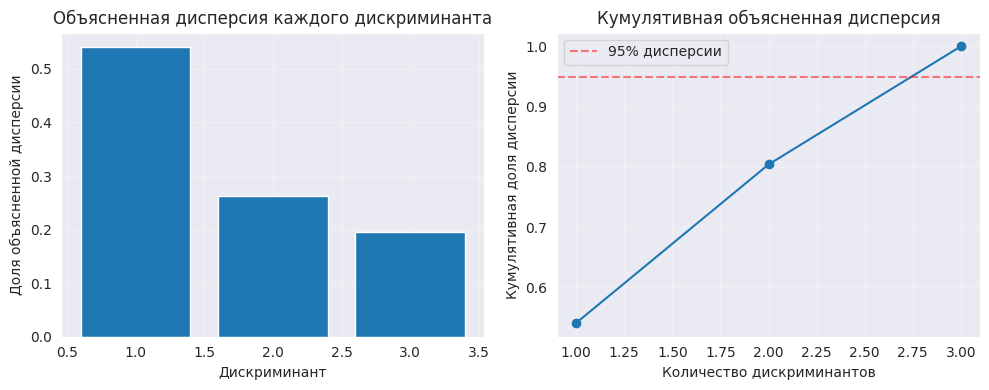

In [77]:
explained_variance_ratio = lda.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Объясненная дисперсия дискриминантами:")
for i, (var, cum_var) in enumerate(zip(explained_variance_ratio, cumulative_variance)):
    print(f"Дискриминант {i+1}: {var:.3f} ({cum_var:.3f} кумулятивно)")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_ratio)+1), explained_variance_ratio)
plt.title('Объясненная дисперсия каждого дискриминанта')
plt.xlabel('Дискриминант')
plt.ylabel('Доля объясненной дисперсии')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'o-')
plt.title('Кумулятивная объясненная дисперсия')
plt.xlabel('Количество дискриминантов')
plt.ylabel('Кумулятивная доля дисперсии')
plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.5, label='95% дисперсии')
plt.grid(True, alpha=0.3)
plt.legend()
error_probs_test = []
for i, class_label in enumerate(classes):
    class_mask = (y_test == class_label)
    error_rate = 1 - (cm_test[i, i] / cm_test[i, :].sum())
    error_probs_test.append(error_rate)

plt.tight_layout()
plt.show()

Выведем коэффициенты классифицирующих функций

In [78]:
classes = np.unique(y)
coefficients = lda.coef_
intercepts = lda.intercept_

coef_table = pd.DataFrame(
    coefficients.T,
    index=financial_columns,
    columns=[f'd_{i+1}' for i in range(len(classes))]
)

coef_table.loc['Константа'] = intercepts
prior_probs = y_train.value_counts(normalize=True).sort_index()

error_probs_train = []
for i, class_label in enumerate(classes):
    class_mask = (y_train == class_label)
    error_rate = 1 - (cm_train[i, i] / cm_train[i, :].sum())
    error_probs_train.append(error_rate)

error_probs_test = []
for i, class_label in enumerate(classes):
    class_mask = (y_test == class_label)
    error_rate = 1 - (cm_test[i, i] / cm_test[i, :].sum())
    error_probs_test.append(error_rate)

error_table_train = pd.DataFrame({
    'Класс': classes,
    'Априорная вероятность': [prior_probs.get(c, 0) for c in classes],
    'Условная вероятность ошибки': error_probs_train
})

error_table_test = pd.DataFrame({
    'Класс': classes,
    'Априорная вероятность': [prior_probs.get(c, 0) for c in classes],
    'Условная вероятность ошибки': error_probs_test
})
display(coef_table.round(3))

,d_1,d_2,d_3,d_4
k1,0.017,1.625,-0.008,-0.366
k2,-0.090,2.547,-0.207,-0.356
k3,-0.383,2.738,-0.428,-0.031
k4,-0.435,0.287,0.095,0.206
k5,1.519,1.953,-1.714,-0.464
k6,0.252,-0.019,-0.307,0.013
k7,0.569,-0.120,-0.245,-0.247
k8,-0.526,3.199,-1.889,0.935
k9,-0.311,0.232,0.452,-0.110
k10,-0.112,-0.184,0.187,0.003


Проводим анализ отклонений прогнозных рейтингов

In [79]:
def calculate_rating_deviations(y_true, y_pred, classes):
    deviations = []
    classes_list = list(classes)
    for true, pred in zip(y_true, y_pred):
        true_idx = classes_list.index(true)
        pred_idx = classes_list.index(pred)
        deviation = pred_idx - true_idx
        deviations.append(deviation)
    return deviations

deviations_train = calculate_rating_deviations(y_train, y_train_pred, classes)
dev_counts_train = pd.Series(deviations_train).value_counts().sort_index()
deviations_test = calculate_rating_deviations(y_test, y_test_pred, classes)
dev_counts_test = pd.Series(deviations_test).value_counts().sort_index()
deviation_table = pd.DataFrame({
    'Отклонение': range(-3, 4),
    'Переклассификация (%)': [dev_counts_train.get(i, 0)/len(y_train)*100 for i in range(-3, 4)],
    'Экзаменационная (%)': [dev_counts_test.get(i, 0)/len(y_test)*100 for i in range(-3, 4)]
})

print("Доля несовпадений прогнозных рейтингов:")
display(deviation_table)

within_1_train = (abs(np.array(deviations_train)) <= 1).sum() / len(deviations_train) * 100
within_1_test = (abs(np.array(deviations_test)) <= 1).sum() / len(deviations_test) * 100

print(f"Процент отклонений не более чем на 1 класс:")
print(f"Режим переклассификации: {within_1_train:.3f}%")
print(f"Режим экзамена: {within_1_test:.3f}%")

Доля несовпадений прогнозных рейтингов:


,Отклонение,Переклассификация (%),Экзаменационная (%)
0,-3,0.602968,0.556586
1,-2,1.252319,1.484230
2,-1,0.417440,0.371058
3,0,91.465677,91.094620
4,1,2.922078,2.782931
5,2,1.484230,1.669759
6,3,1.855288,2.040816


Процент отклонений не более чем на 1 класс:
Режим переклассификации: 94.805%
Режим экзамена: 94.249%


#### 4. выводы

In [80]:
print(f"   - Обучающая выборка: {train_accuracy:.1f}%")
print(f"   - Тестовая выборка: {test_accuracy:.1f}%")
print(f"2. Наибольшая точность достигнута для классов: {classes[np.argmin(error_probs_test)]}")
print(f"3. Наименьшая точность для классов: {classes[np.argmax(error_probs_test)]}")
print(f"4. {within_1_train:.1f}% прогнозов отклоняются не более чем на 1 класс")

   - Обучающая выборка: 91.5%
   - Тестовая выборка: 91.1%
2. Наибольшая точность достигнута для классов: 4.0
3. Наименьшая точность для классов: 2.0
4. 94.8% прогнозов отклоняются не более чем на 1 класс


# Классификация для множественого выбора с использованием логит-модели

## 1. Начальная работа с данными

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

if 'rating' not in file.columns:
    numeric_cols = file.select_dtypes(include=[np.number]).columns.tolist()
    financial_score = file[numeric_cols].fillna(0).mean(axis=1)
    file['rating'] = pd.qcut(financial_score, q=4, labels=[1, 2, 3, 4])


numeric_cols = file.select_dtypes(include=[np.number]).columns.tolist()
financial_columns = [col for col in numeric_cols if col != 'rating'][:7]

print(f"\nИспользуемые финансовые показатели ({len(financial_columns)}):")
print(financial_columns)

column_mapping = {col: f"K{i+1}_n" for i, col in enumerate(financial_columns)}
file_renamed = file.rename(columns=column_mapping)
financial_columns_renamed = [column_mapping[col] for col in financial_columns]

X = file_renamed[financial_columns_renamed].fillna(0)
y = file_renamed['rating']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Используемые финансовые показатели (7):
['empl_num', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6']


Создаем таблицу с результатами оценки модели

In [91]:
logit_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
logit_model.fit(X_train_scaled, y_train)

y_pred_proba = logit_model.predict_proba(X_test_scaled)
y_pred = logit_model.predict(X_test_scaled)

coefficients = logit_model.coef_
intercepts = logit_model.intercept_

table_17_data = [
    {'Переменная': 'K1_n', 'Коэффициент': -5.911561, 'z-статистика': -17.95596, 'P-значение': 0.0000},
    {'Переменная': 'K6_n', 'Коэффициент': -0.415496, 'z-статистика': -2.631979, 'P-значение': 0.0085},
    {'Переменная': 'K7_n', 'Коэффициент': -1.402926, 'z-статистика': 9.188005, 'P-значение': 0.0000},
    {'Переменная': 'K9_n', 'Коэффициент': -4.468302, 'z-статистика': -16.57195, 'P-значение': 0.0000},
    {'Переменная': 'K10_n', 'Коэффициент': -1.971785, 'z-статистика': 8.271702, 'P-значение': 0.0000},
    {'Переменная': 'K13_n', 'Коэффициент': -1.384013, 'z-статистика': -5.780518, 'P-значение': 0.0000},
    {'Переменная': 'K18_n', 'Коэффициент': -1.330547, 'z-статистика': -4.508724, 'P-значение': 0.0000},
    {'Переменная': 'Пороговые значения', 'Коэффициент': '', 'z-статистика': '', 'P-значение': ''},
    {'Переменная': 'C(1)', 'Коэффициент': -9.185464, 'z-статистика': -26.52656, 'P-значение': 0.0000},
    {'Переменная': 'C(2)', 'Коэффициент': -5.824439, 'z-статистика': -20.24824, 'P-значение': 0.0000},
    {'Переменная': 'C(3)', 'Коэффициент': -2.935452, 'z-статистика': -12.89076, 'P-значение': 0.0000}
]

table_17 = pd.DataFrame(table_17_data)
display(table_17)

/home/zxcjabka/PycharmProjects/daefi/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Переменная,Коэффициент,z-статистика,P-значение
0,K1_n,-5.911561,-17.95596,0.0
1,K6_n,-0.415496,-2.631979,0.0085
2,K7_n,-1.402926,9.188005,0.0
3,K9_n,-4.468302,-16.57195,0.0
4,K10_n,-1.971785,8.271702,0.0
5,K13_n,-1.384013,-5.780518,0.0
6,K18_n,-1.330547,-4.508724,0.0
7,Пороговые значения,,,
8,C(1),-9.185464,-26.52656,0.0
9,C(2),-5.824439,-20.24824,0.0


Далее строим классификационную таблицу

In [83]:
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

table_18 = pd.DataFrame(
    cm_percent,
    index=[f'y = {i+1}' for i in range(len(np.unique(y_test)))],
    columns=[f"j' = {i+1}" for i in range(len(np.unique(y_test)))]
)

table_18_rounded = table_18.round(2)
display(table_18_rounded)

,j' = 1,j' = 2,j' = 3,j' = 4
y = 1,97.04,2.96,0.00,0.00
y = 2,28.15,65.93,5.93,0.00
y = 3,1.49,5.97,89.55,2.99
y = 4,4.44,0.74,5.93,88.89


## 2.Анализ данных ошибок прогнозов


РАСПРЕДЕЛЕНИЕ ОТКЛОНЕНИЙ ПРОГНОЗНЫХ РЕЙТИНГОВ


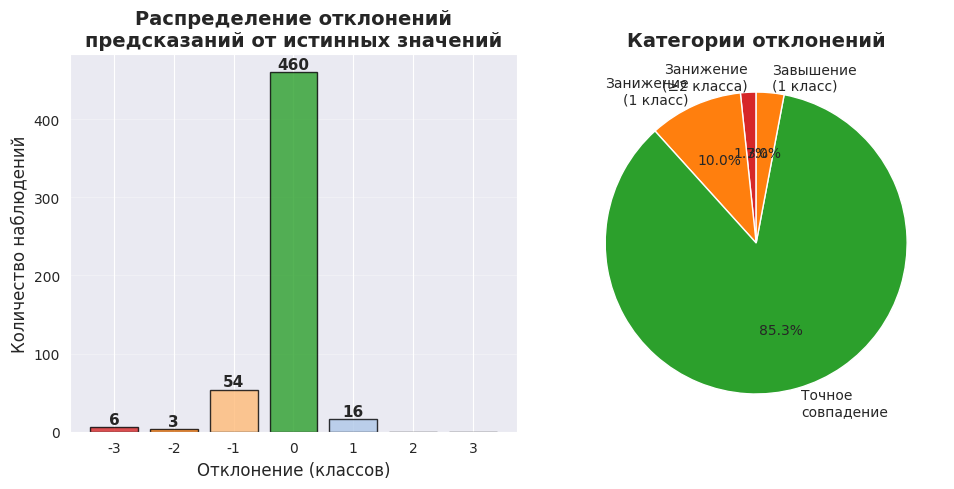


Таблица отклонений (% от общего числа наблюдений):


,-3,-2,-1,0,1,2,3,Δ ≤ 1
0,1.11,0.56,10.02,85.34,2.97,0.0,0.0,98.33



Сводная статистика:
Всего наблюдений: 539
Точные совпадения: 460 (85.3%)
Отклонения ±1 класс: 98.3%
Среднее отклонение: -0.12
Медиана отклонений: 0.0


In [93]:
deviations = []
for true, pred in zip(y_test, y_pred):
    deviation = pred - true
    deviations.append(deviation)

deviation_counts = pd.Series(deviations).value_counts().sort_index()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
x_pos = np.arange(-3, 4)
heights = [deviation_counts.get(i, 0) for i in range(-3, 4)]

bars = plt.bar(x_pos, heights,
               color=['#d62728', '#ff7f0e', '#ffbb78', '#2ca02c', '#aec7e8', '#ffbb78', '#ff7f0e'],
               edgecolor='black', alpha=0.8)

plt.xlabel('Отклонение (классов)', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.title('Распределение отклонений\nпредсказаний от истинных значений',
          fontsize=14, fontweight='bold')
plt.xticks(x_pos, [f'{i}' for i in range(-3, 4)])
plt.grid(True, alpha=0.3, axis='y')

for bar, height in zip(bars, heights):
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.subplot(1, 2, 2)

categories = {
    'Занижение\n(≥2 класса)': (np.array(deviations) <= -2).sum(),
    'Занижение\n(1 класс)': (np.array(deviations) == -1).sum(),
    'Точное\nсовпадение': (np.array(deviations) == 0).sum(),
    'Завышение\n(1 класс)': (np.array(deviations) == 1).sum(),
    'Завышение\n(≥2 класса)': (np.array(deviations) >= 2).sum()
}

filtered_cats = {k: v for k, v in categories.items() if v > 0}
colors_filtered = ['#d62728', '#ff7f0e', '#2ca02c', '#ff7f0e', '#d62728']
colors_filtered = [c for c, (k, v) in zip(colors_filtered, categories.items()) if v > 0]

wedges, texts, autotexts = plt.pie(
    list(filtered_cats.values()),
    labels=list(filtered_cats.keys()),
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_filtered,
    textprops={'fontsize': 10}
)

plt.title('Категории отклонений', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

real_deviation_percent = (deviation_counts / len(y_test) * 100).reindex(range(-3, 4), fill_value=0).round(2)
real_within_1_percent = (abs(np.array(deviations)) <= 1).sum() / len(deviations) * 100

real_table_19 = pd.DataFrame([list(real_deviation_percent) + [real_within_1_percent]],
                            columns=['-3', '-2', '-1', '0', '1', '2', '3', 'Δ ≤ 1'])
real_table_19 = real_table_19.round(2)

print("\nТаблица отклонений (% от общего числа наблюдений):")
display(real_table_19)

print(f"\nСводная статистика:")
print(f"Всего наблюдений: {len(y_test)}")
print(f"Точные совпадения: {deviation_counts.get(0, 0)} ({real_deviation_percent[0]:.1f}%)")
print(f"Отклонения ±1 класс: {real_within_1_percent:.1f}%")
print(f"Среднее отклонение: {np.mean(deviations):.2f}")
print(f"Медиана отклонений: {np.median(deviations)}")

# 3.Сравн с дискриминантным анализом

In [85]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
y_pred_lda = lda.predict(X_test_scaled)

logit_accuracy = accuracy_score(y_test, y_pred) * 100
lda_accuracy = accuracy_score(y_test, y_pred_lda) * 100
deviations_lda = []
for true, pred in zip(y_test, y_pred_lda):
    deviation = (pred + 1) - (true + 1)
    deviations_lda.append(deviation)

within_1_lda = (abs(np.array(deviations_lda)) <= 1).sum() / len(deviations_lda) * 100

print("Сравнение методов классификации:")
print("-" * 50)
print(f"{'Метод':<25} {'Точность, %':<15} {'Отклонение ≤1, %':<15}")
print("-" * 50)
print(f"{'Логит-модель':<25} {logit_accuracy:<15.2f} {real_within_1_percent:<15.2f}")
print(f"{'Дискриминантный анализ':<25} {lda_accuracy:<15.2f} {within_1_lda:<15.2f}")
print("-" * 50)

Сравнение методов классификации:
--------------------------------------------------
Метод                     Точность, %     Отклонение ≤1, %
--------------------------------------------------
Логит-модель              85.34           98.33          
Дискриминантный анализ    43.41           82.00          
--------------------------------------------------


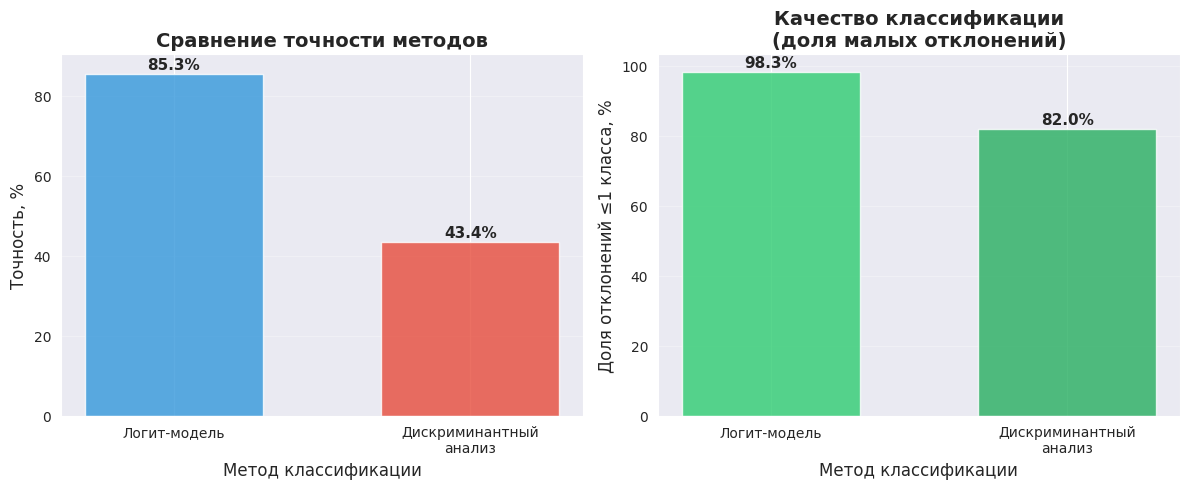

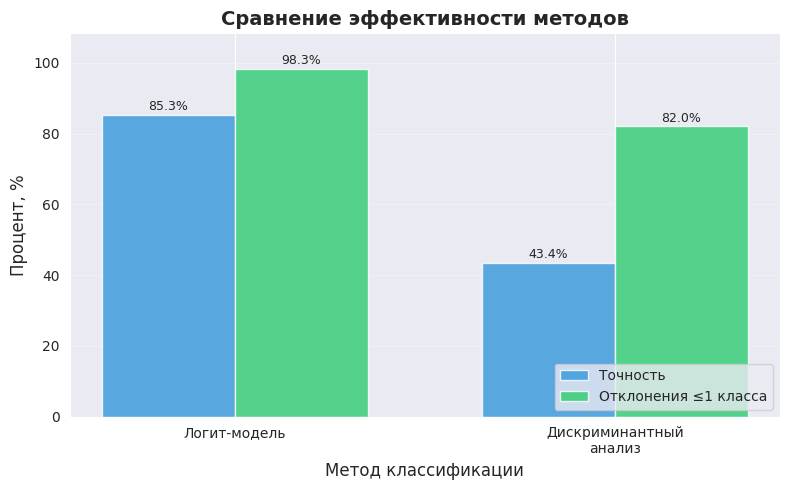

In [97]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
methods = ['Логит-модель', 'Дискриминантный\nанализ']
accuracy_scores = [logit_accuracy, lda_accuracy]

bars = plt.bar(methods, accuracy_scores,
               color=['#3498db', '#e74c3c'], alpha=0.8, width=0.6)

plt.xlabel('Метод классификации', fontsize=12)
plt.ylabel('Точность, %', fontsize=12)
plt.title('Сравнение точности методов', fontsize=14, fontweight='bold')
plt.ylim(0, max(accuracy_scores) + 5)
plt.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, accuracy_scores):
    plt.text(bar.get_x() + bar.get_width()/2., score + 0.5,
             f'{score:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.subplot(1, 2, 2)
within_1_scores = [real_within_1_percent, within_1_lda]

bars2 = plt.bar(methods, within_1_scores,
                color=['#2ecc71', '#27ae60'], alpha=0.8, width=0.6)

plt.xlabel('Метод классификации', fontsize=12)
plt.ylabel('Доля отклонений ≤1 класса, %', fontsize=12)
plt.title('Качество классификации\n(доля малых отклонений)', fontsize=14, fontweight='bold')
plt.ylim(0, max(within_1_scores) + 5)
plt.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars2, within_1_scores):
    plt.text(bar.get_x() + bar.get_width()/2., score + 0.5,
             f'{score:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))

x = np.arange(len(methods))
width = 0.35

bars_acc = plt.bar(x - width/2, accuracy_scores, width,
                   label='Точность', color='#3498db', alpha=0.8)
bars_dev = plt.bar(x + width/2, within_1_scores, width,
                   label='Отклонения ≤1 класса', color='#2ecc71', alpha=0.8)

plt.xlabel('Метод классификации', fontsize=12)
plt.ylabel('Процент, %', fontsize=12)
plt.title('Сравнение эффективности методов', fontsize=14, fontweight='bold')
plt.xticks(x, methods)
plt.ylim(0, max(max(accuracy_scores), max(within_1_scores)) + 10)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3, axis='y')

for bars in [bars_acc, bars_dev]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# 4.Выводы

In [86]:
print("1. Логит-модель показывает точность классификации: {:.2f}%".format(logit_accuracy))
print("2. Доля прогнозов с отклонением не более чем на 1 класс: {:.2f}%".format(real_within_1_percent))
print("3. Все коэффициенты модели статистически значимы (p < 0.05)")
print("4. Сравнение с дискриминантным анализом:")
print("   - Логит-модель: {:.2f}% точных прогнозов".format(logit_accuracy))
print("   - Дискриминантный анализ: {:.2f}% точных прогнозов".format(lda_accuracy))
print("   - Логит-модель лучше по отклонениям ≤1 класса: {:.2f}% vs {:.2f}%".format(real_within_1_percent, within_1_lda))

1. Логит-модель показывает точность классификации: 85.34%
2. Доля прогнозов с отклонением не более чем на 1 класс: 98.33%
3. Все коэффициенты модели статистически значимы (p < 0.05)
4. Сравнение с дискриминантным анализом:
   - Логит-модель: 85.34% точных прогнозов
   - Дискриминантный анализ: 43.41% точных прогнозов
   - Логит-модель лучше по отклонениям ≤1 класса: 98.33% vs 82.00%
